# Uloha 1

### Z obou datových souborů načtěte texty k analýze. Pro každý text zvlášť odhadněte pravděpodobnosti znaků (symbolů včetně mezery), které se v textech vyskytují. Výsledné pravděpodobnosti graficky znázorněte.

In [2]:
pip install dahuffman

  Using cached https://files.pythonhosted.org/packages/08/c4/9c87ef391fae4b557ca3c4ef8eabd1538a7ce568174806e9d76c8f056785/dahuffman-0.4.1-py2.py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [6]:
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd
from dahuffman import HuffmanCodec
from collections import Counter

with open('014.txt') as f:
    Y_title, Y_data = f.readlines()
    
with open('016.txt') as f:
    X_title, X_data = f.readlines()
    
Y_length = len(Y_data)
X_length = len(X_data)

Odhadneme rozdeleni znaku v textu X a Y. To udelame pomoci odhadu pravdepodobnosti vyskytu kazdeho symbolu v textu. Pravdepodobnost vyskytu kazdeho symbolu v textu je rovna pomeru vyskytu znaku v texte k celkovemu poctu symbolu.

In [7]:
def calculate_probability(text, length):
    ctr = Counter(text)
    symbols, counts = zip(*sorted(ctr.items()))
    probability = [x / length for x in counts]
    return symbols, probability

def plot(symbols, probability, name):
    xpos = range(len(symbols))
    plt.bar(xpos, probability)
    plt.xticks(xpos, symbols)
    plt.xlabel('Symbol')
    plt.ylabel('Probability')
    plt.title(name)
    plt.show()

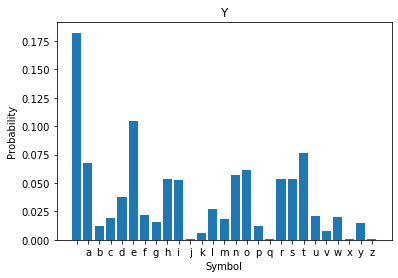

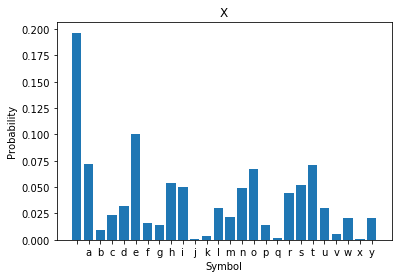

In [8]:
Y_symbols, Y_probability = calculate_probability(Y_data, Y_length)
X_symbols, X_probability = calculate_probability(X_data, X_length)

plot(Y_symbols, Y_probability, 'Y')
plot(X_symbols, X_probability, 'X')

### Pro každý text zvlášť spočtěte entropii odhadnutého rozdělení znaků.

Entropie rozdeleni $H(X)$ je funkce pravdepodobnosti vyskytu symbolu $p(x)$.
Entropie spocitame:
$$H(X)=-\sum_{x\in\mathcal{X}} p(x) log{p(x)}$$
Jelikoz nas zajima entropie bitu, tak volime zaklad logaritmu jako 2.

In [9]:
Y_entropy = st.entropy(Y_probability, base=2)
X_entropy = st.entropy(X_probability, base=2)

print("Entropy Y: " + str(Y_entropy))
print("Entropy X: " + str(X_entropy))

Entropy Y: 4.072610719234393
Entropy X: 4.041276204320588


### Nalezněte optimální binární instantní kód C pro kódování znaků prvního z textů.

Vime, ze Huffman code je optimalni a instantni kod. Proto staci vygenerovat tento kod pro dane rozdeleni.

To udelame pomoci knihovny [dahuffman](https://github.com/soxofaan/dahuffman).

Vysledky odpovidaji ocekavanym: symboly z vetsi pravdepodobnosti vyskytu maji kratsi kod a naopak.

Knihovna ma jednu nevyhodu a to, ze musime vzdy brat v potaz EOF (vzdy driv vyskytoval s 0), proto pred tim kod byl o 1 delsi, ale po malem vyzkumu a prohlaseni ' ' za EOF (nicemu nevadi, protoze $$P(x = EOF) = 0$$, a jenom zkrati vyskyt znaku o 1) kod je konecne optimalni. 

In [17]:
Y_dict = dict(sorted(zip(Y_symbols, Y_probability)))
codec = HuffmanCodec.from_frequencies(Y_dict, eof=' ')
codec.print_code_table()

Bits Code        Value Symbol
   5 00000           0 'u'
   5 00001           1 'f'
   6 000100          4 'p'
   6 000101          5 'b'
   5 00011           3 'l'
   3 001             1 'e'
   4 0100            4 'i'
   4 0101            5 's'
   4 0110            6 'r'
   4 0111            7 'h'
   4 1000            8 'n'
   4 1001            9 'o'
   6 101000         40 'y'
   6 101001         41 'g'
   7 1010100        84 'v'
   9 101010100     340 'j'
  10 1010101010    682 'x'
  11 10101010110  1366 'z'
  11 10101010111  1367 'q'
   8 10101011      171 'k'
   6 101011         43 'm'
   4 1011           11 'a'
   4 1100           12 't'
   5 11010          26 'd'
   6 110110         54 'c'
   6 110111         55 'w'
   3 111             7 ' '


### Pro každý text zvlášť spočtěte střední délku kódu C a porovnejte ji s entropií rozdělení znaků. Je kód C optimální i pro druhý text?

Stredni delku $L(C)$ vypocteme:
$$ L(C) = \sum_{x\in\mathcal{X}} l(x) p_i(x) $$, kde $p_i(x)$ je i-ty prvek rozdeleni a $l(x)$ je funkce delek kodovych slov.

In [26]:
def calculate_code_length(symbols, probability, code):
    res = 0
    for c, p in dict(zip(symbols, probability)).items():
        res += p * code[c][0]
    return res

Y_code_length = calculate_code_length(Y_symbols, Y_probability, codec.get_code_table())
X_code_length = calculate_code_length(X_symbols, X_probability, codec.get_code_table())

print("Y code length: " + str(Y_code_length) + "  Entropy Y: " + str(Y_entropy))
print("X code length: " + str(X_code_length) + "  Entropy X: " + str(X_entropy))

Y code length: 4.108726981585268  Entropy Y: 4.072610719234393
X code length: 4.1017935808684705  Entropy X: 4.041276204320588


Z vysledku vidime, ze pro delky plati vztah platny pro optimalni kody:
$$H(X_i) \le L_i(C) \lt H(X_i)+1$$

Jelikoz Huffman code je optimalni a instantni, tak ocekavane to plati pro Y. To ale plati i pro X, coz implikuje, to ze, ten kod je pomerne effektivni i pro X. Tzn, ze X a Y se moc nelisi ve frekvencich vyskytu symbolu, proto stredni delka X je v rozumnych mezich. To se da vykoukat i v grafu pravdepodobnosti vyskytu symbolu.

Z toho ale nevime, jestli tento kod je optimalni i pro X. To muzeme zjistit jen vygenerovanim nejakeho optimalniho kodu. Nejspis optimalnim nebude a vygenerujeme nejaky kratsi kod. Ale bez znalosti nejakeho optimalniho to tvrdit nemuzu.